## **Machine Learning Project - Facial Emotion Recognition**

In [ ]:
# Setup
!pip install gdown
fileID = "1wEHWgQuDmNt8HPTgnhmyrpgGIhH5xBgw"

!gdown --id {fileID} -O fer2013.csv

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1wEHWgQuDmNt8HPTgnhmyrpgGIhH5xBgw
From (redirected): https://drive.google.com/uc?id=1wEHWgQuDmNt8HPTgnhmyrpgGIhH5xBgw&confirm=t&uuid=19e73c60-655e-40ad-8aa3-acb89e35325c
To: /content/fer2013.csv
100% 301M/301M [00:05<00:00, 50.9MB/s]


In [ ]:
# import libraries
import cv2
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from flask import Flask
from flask_ngrok import run_with_ngrok
import pickle
from torch.utils.data import TensorDataset, DataLoader, random_split

# Loading Data


In [ ]:

# load dataset
facial_df = pd.read_csv('fer2013.csv')
facial_df.tail(10)

,emotion,pixels,Usage
35877,6,139 143 145 154 159 168 176 181 190 191 195 19...,PrivateTest
35878,3,0 39 81 80 104 97 51 64 68 46 41 67 53 68 70 5...,PrivateTest
35879,2,0 0 6 16 19 31 47 18 26 19 17 8 15 3 4 2 14 20...,PrivateTest
35880,2,164 172 175 171 172 173 178 181 188 192 197 20...,PrivateTest
35881,0,181 177 176 156 178 144 136 132 122 107 131 16...,PrivateTest
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest
35886,2,19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...,PrivateTest


In [ ]:
# Checking the different data usage available
facial_df.Usage.unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [ ]:
# Checking the different emotions available
facial_df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [ ]:
# define dictionary of emotions with corresponding numerical label
facial_emotion_labels = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness',
                         4: 'sadness', 5: 'surprise', 6: 'neutral'}

# Processing Data

In [ ]:
# split string of pixel values and convert to numpy array (lambda func is
# quicker, takes half the time :) ~B )
# for i in range(len(facial_df)):
#   facial_df.iat[i, 1] = np.array(facial_df.iloc[i, 1].split(' ')).astype('float32')
facial_df['pixels'] = facial_df['pixels'].str.split(' ').apply(lambda x: np.array(x, dtype='float32'))

In [ ]:
# convert numpy arrays to tensors
for i in range(len(facial_df)):
  facial_df.iat[i, 1] = torch.tensor(facial_df.iloc[i, 1])

In [ ]:
# Divide the dataset for training, validation (subpart of training used to
# evaluate performance, will tune parameters) and testing

train_df = facial_df[facial_df['Usage'] == 'Training']
validation_df = facial_df[facial_df['Usage'] == 'PublicTest']
test_df = facial_df[facial_df['Usage'] == 'PrivateTest']

In [ ]:
# gather all input tensors
input_train_tensors = [train_df.iloc[i, 1] for i in range(len(train_df))]
input_train_data = torch.stack(input_train_tensors)

input_validation_tensors = [validation_df.iloc[i, 1]
                            for i in range(len(validation_df))]
input_validation_data = torch.stack(input_validation_tensors)

input_test_tensors = [test_df.iloc[i, 1] for i in range(len(test_df))]
input_test_data = torch.stack(input_test_tensors)

In [ ]:
# convert class data to tensor
output_train_data = torch.tensor(train_df.iloc[:, 0], dtype=torch.int64)
output_validation_data = torch.tensor(validation_df.iloc[:, 0].values,
                                      dtype=torch.int64)
output_test_data = torch.tensor(test_df.iloc[:, 0].values, dtype=torch.int64)

In [ ]:
# create tensor dataset

train_dataset = TensorDataset(
    input_train_data,
    output_train_data
)

validation_dataset = TensorDataset(
    input_validation_data,
    output_validation_data
)

test_dataset = TensorDataset(
    input_test_data,
    output_test_data
)

In [ ]:
# create dataloaders
# train_dataloader = DataLoader(facial_dataset, batch_size=32)

# Create DataLoaders for each subset
# Shuffle training data for randomization
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32)
test_dataloader = DataLoader(test_dataset, batch_size=32)

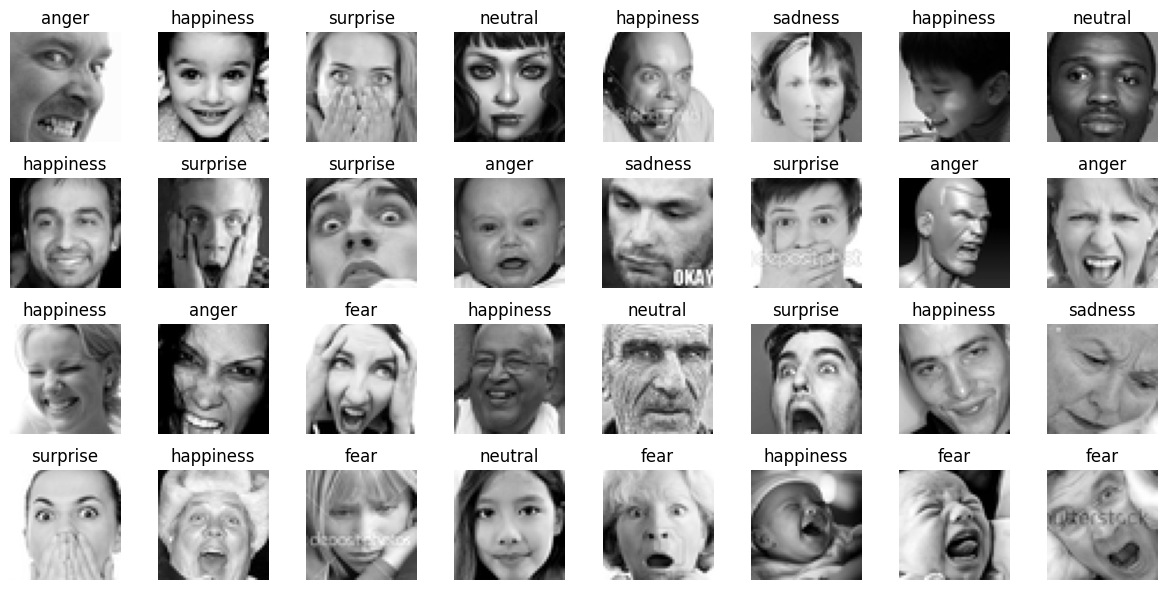

In [ ]:
# Get a batch of images and labels from the dataloader
for batch_idx, (images, labels) in enumerate(train_dataloader):
  images = images.reshape(-1, 48, 48)

  fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(12, 6))
  for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(facial_emotion_labels[labels[i].item()])
    ax.axis('off')

  plt.tight_layout()
  plt.show()

  # Displaying first batch only for visualisation
  break

Imports

In [ ]:
!pip install lightning
from lightning.pytorch import LightningModule
from torch import Tensor
import torchmetrics
from torch import nn
from typing import Tuple
from importlib import reload
import torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 38.4 MB/s eta 0:00:00


More Data Preperation

In [ ]:
"""
  Main point of this function is to make sure the data is shaped correctly, the previous cells make the shape
  (32, 2304) which is a 2D array, but we want a 4D array for the convolution.

  Side note: 2304 comes from 48*48 we do not want this, we want 48 * 48 hense the reshape below
"""

from torch.utils.data import DataLoader, Dataset

class FacialDataset(Dataset):
    def __init__(self, inputs, outputs):
      self.inputs = inputs
      self.outputs = outputs

    def __len__(self):
      return len(self.outputs)

    def __getitem__(self, idx):
        # Add channel dimension
        x = self.inputs[idx].reshape(1, 48, 48)
        y = self.outputs[idx]
        return x, y

# Update datasets
train_dataset = FacialDataset(input_train_data, output_train_data)
validation_dataset = FacialDataset(input_validation_data, output_validation_data)
test_dataset = FacialDataset(input_test_data, output_test_data)

# Update DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32)
test_dataloader = DataLoader(test_dataset, batch_size=32)

Base model from assignment 2

In [ ]:
class BaseModel(LightningModule):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.accuracy = torchmetrics.classification.Accuracy(
            task="multiclass",
            num_classes=num_classes)
        self.model = self.build_model()

    def build_model(self):
        raise Exception("Not yet implemented")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

    def forward(self, x):
        return self.model(x)

    def loss(self, logits, target):
        return nn.functional.cross_entropy(logits, target)

    def shared_step(self, mode:str, batch:Tuple[Tensor, Tensor], batch_index:int):
        x, target = batch
        output = self.forward(x)
        loss = self.loss(output, target)
        self.accuracy(output, target)
        self.log(f"{mode}_step_acc", self.accuracy, prog_bar=True)
        self.log(f"{mode}_step_loss", loss, prog_bar=False)
        return loss

    def training_step(self, batch, batch_index):
        return self.shared_step('train', batch, batch_index)

    def validation_step(self, batch, batch_index):
        return self.shared_step('val', batch, batch_index)

    def test_step(self, batch, batch_index):
        return self.shared_step('test', batch, batch_index)


# Neural Network - CNN


In [ ]:
# Note this is quite a simple ConvNet, this was for testing purposes
# Our dataset is quite complex so this will not yield a good acc
# I've added an extra layer to it, and it increased the acc, so just play around with it, add layers
# change values, change kernel size ect..


# TODO: Make a more complex and capable ConvNet
class ConvNet(BaseModel):
    def __init__(self, num_classes, num_kernels, kernel_size, pool_size):
        self.num_kernels = num_kernels
        self.kernel_size = kernel_size
        self.pool_size = pool_size
        super().__init__(num_classes)

    def build_model(self):
        return nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=self.num_kernels, kernel_size=self.kernel_size, padding='same'),
            nn.MaxPool2d(kernel_size=self.pool_size),
            nn.ReLU(),
            nn.Conv2d(self.num_kernels, self.num_kernels*2, kernel_size=self.kernel_size, padding='same'),  # Add more filters
            nn.MaxPool2d(kernel_size=self.pool_size),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(self.num_kernels * 2 * 12 * 12, self.num_classes)
        )

Training model from assignment 2

In [ ]:
import shutil
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch import Trainer, seed_everything

def train(model, max_epochs):
    name = model.__class__.__name__
    shutil.rmtree(f'./lightning_logs/{name}', ignore_errors=True)
    seed_everything(0, workers=True)
    logger = CSVLogger('./lightning_logs', name=name)

    # Disable deterministic behavior for operations like
    # 'adaptive_avg_pool2d' without CUDA support (vgg)
    trainer = Trainer(max_epochs=max_epochs, logger=logger, deterministic=False)
    trainer.fit(model,
                train_dataloaders=train_dataloader,
                val_dataloaders=validation_dataloader)

In [ ]:
num_of_classes = len(facial_df.emotion.unique())

In [ ]:
# initialize model
model = ConvNet(num_of_classes, 10, 3, 2)

In [ ]:
model

ConvNet(
  (accuracy): MulticlassAccuracy()
  (model): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2880, out_features=7, bias=True)
  )
)

In [ ]:
# Change epoch here
train(model, max_epochs=10)

INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | accuracy | MulticlassAccuracy | 0      | train
1 | model    | Sequential         | 22.1 K | train
--------------------------------------------------------
22.1 K    Trainable params
0         Non-trainable params
22.1 K    Total params
0.088     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name     | Type               | Params | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Graphing

In [ ]:
import pandas as pd

def show_metrics(name, metric):
    train_col = f'train_step_{metric}'
    val_col = f'val_step_{metric}'
    df = pd.read_csv(f'./lightning_logs/{name}/version_0/metrics.csv')
    df.set_index('step', inplace=True)
    ax = df[[train_col]].dropna().plot()
    df[[val_col]].dropna().plot(ax=ax);
    return df[[val_col]].dropna().round(2)

,val_step_acc
step,
897,0.29
1795,0.38
2693,0.43
3591,0.45
4489,0.47
5387,0.49
6285,0.50
7183,0.52
8081,0.53


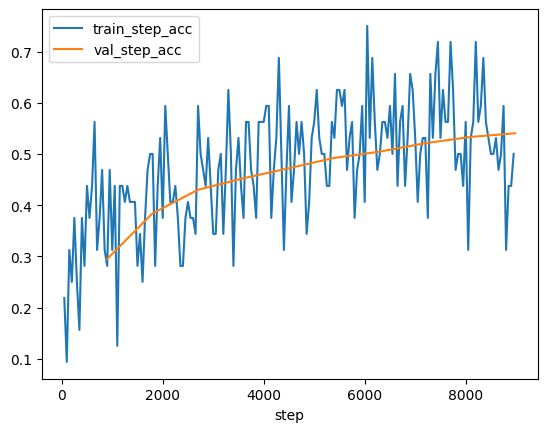

In [ ]:
show_metrics('ConvNet', 'acc')

,val_step_loss
step,
897,1.67
1795,1.56
2693,1.53
3591,1.57
4489,1.52
5387,1.53
6285,1.54
7183,1.51
8081,1.52


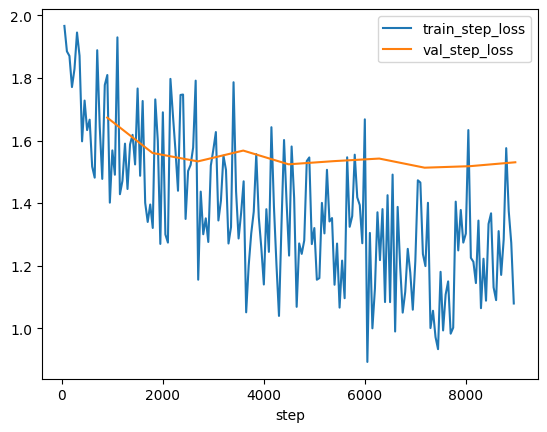

In [ ]:
show_metrics('ConvNet', 'loss')

# VGG16

In [ ]:
from torchvision.models import vgg16, VGG16_Weights
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

In [ ]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [ ]:
# initialize model
pre_trained_vgg = vgg16(weights=VGG16_Weights.DEFAULT)

In [ ]:
# change input channels to 1 in first convolution
pre_trained_vgg.features[0] = nn.Conv2d(1, 64, kernel_size=(3,3), stride=(1, 1), padding=(1, 1))
# change out_features to number of classes
pre_trained_vgg.classifier[-1] = nn.Linear(in_features=4096, out_features=num_of_classes)

In [ ]:
pre_trained_vgg.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Training function
def train_model(model, train_dataloader, criterion, optimizer, device, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct, total = 0, 0
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}")

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Metrics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update progress bar
            progress_bar.set_postfix(loss=running_loss / (total // labels.size(0)), acc=correct / total)

        print(f"Epoch {epoch+1} Loss: {running_loss/len(train_dataloader):.4f}, Acc: {100*correct/total:.2f}%")


In [ ]:
# Testing function
def test_model(model, dataloader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [ ]:
# Inference on some images
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from tqdm import tqdm

def test_model_first20(model, validation_dataloader, device):
    model.eval()
    correct, total = 0, 0
    first_20_images = []
    first_20_actual = []
    first_20_predicted = []

    with torch.no_grad():
        for inputs, labels in tqdm(validation_dataloader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Track accuracy
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect first 10 samples for visualization
            if len(first_20_images) < 20:
                for i in range(inputs.size(0)):
                    if len(first_20_images) < 20:
                        first_20_images.append(inputs[i].cpu())
                        first_20_actual.append(labels[i].item())
                        first_20_predicted.append(predicted[i].item())

    # Calculate accuracy
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

    # Plot first 10 images with actual vs predicted labels
    fig, axes = plt.subplots(4, 5, figsize=(15, 6))
    fig.suptitle("First 20 Images: Actual vs Predicted Labels", fontsize=16)
    for idx, ax in enumerate(axes.flat):
        img = first_20_images[idx]
        img = img.squeeze(0)  # Remove channel dimension for grayscale images
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        ax.set_title(f"Actual: {first_20_actual[idx]}\nPred: {first_20_predicted[idx]}")
    plt.tight_layout()
    plt.show()

    return accuracy


In [ ]:
# Training Setup
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(pre_trained_vgg.parameters(), lr=0.001)

## Training

In [ ]:
# Run Training

num_epochs = 20
train_model(pre_trained_vgg, train_dataloader, criterion, optimizer, device, epochs=num_epochs)

Epoch 1/20: 100%|██████████| 898/898 [00:41<00:00, 21.83it/s, acc=0.246, loss=0.286]


Epoch 1 Loss: 1.8314, Acc: 24.64%


Epoch 2/20: 100%|██████████| 898/898 [00:40<00:00, 22.09it/s, acc=0.255, loss=0.28]


Epoch 2 Loss: 1.7931, Acc: 25.48%


Epoch 3/20: 100%|██████████| 898/898 [00:40<00:00, 21.99it/s, acc=0.288, loss=0.274]


Epoch 3 Loss: 1.7507, Acc: 28.81%


Epoch 4/20: 100%|██████████| 898/898 [00:40<00:00, 22.00it/s, acc=0.335, loss=0.261]


Epoch 4 Loss: 1.6682, Acc: 33.48%


Epoch 5/20: 100%|██████████| 898/898 [00:40<00:00, 21.94it/s, acc=0.374, loss=0.25]


Epoch 5 Loss: 1.5952, Acc: 37.37%


Epoch 6/20: 100%|██████████| 898/898 [00:40<00:00, 21.95it/s, acc=0.399, loss=0.241]


Epoch 6 Loss: 1.5420, Acc: 39.92%


Epoch 7/20: 100%|██████████| 898/898 [00:41<00:00, 21.84it/s, acc=0.423, loss=0.233]


Epoch 7 Loss: 1.4906, Acc: 42.30%


Epoch 8/20: 100%|██████████| 898/898 [00:41<00:00, 21.82it/s, acc=0.447, loss=0.225]


Epoch 8 Loss: 1.4370, Acc: 44.66%


Epoch 9/20: 100%|██████████| 898/898 [00:41<00:00, 21.87it/s, acc=0.462, loss=0.218]


Epoch 9 Loss: 1.3967, Acc: 46.16%


Epoch 10/20: 100%|██████████| 898/898 [00:41<00:00, 21.74it/s, acc=0.478, loss=0.213]


Epoch 10 Loss: 1.3586, Acc: 47.81%


Epoch 11/20: 100%|██████████| 898/898 [00:41<00:00, 21.88it/s, acc=0.491, loss=0.207]


Epoch 11 Loss: 1.3249, Acc: 49.14%


Epoch 12/20: 100%|██████████| 898/898 [00:40<00:00, 21.91it/s, acc=0.507, loss=0.202]


Epoch 12 Loss: 1.2942, Acc: 50.67%


Epoch 13/20: 100%|██████████| 898/898 [00:41<00:00, 21.89it/s, acc=0.522, loss=0.197]


Epoch 13 Loss: 1.2617, Acc: 52.17%


Epoch 14/20: 100%|██████████| 898/898 [00:41<00:00, 21.88it/s, acc=0.533, loss=0.193]


Epoch 14 Loss: 1.2318, Acc: 53.26%


Epoch 15/20: 100%|██████████| 898/898 [00:41<00:00, 21.90it/s, acc=0.544, loss=0.188]


Epoch 15 Loss: 1.2042, Acc: 54.41%


Epoch 16/20: 100%|██████████| 898/898 [00:41<00:00, 21.85it/s, acc=0.559, loss=0.184]


Epoch 16 Loss: 1.1784, Acc: 55.86%


Epoch 17/20: 100%|██████████| 898/898 [00:41<00:00, 21.90it/s, acc=0.564, loss=0.18]


Epoch 17 Loss: 1.1482, Acc: 56.40%


Epoch 18/20: 100%|██████████| 898/898 [00:40<00:00, 21.90it/s, acc=0.574, loss=0.176]


Epoch 18 Loss: 1.1253, Acc: 57.40%


Epoch 19/20: 100%|██████████| 898/898 [00:41<00:00, 21.85it/s, acc=0.591, loss=0.171]


Epoch 19 Loss: 1.0960, Acc: 59.07%


Epoch 20/20: 100%|██████████| 898/898 [00:41<00:00, 21.87it/s, acc=0.596, loss=0.168]

Epoch 20 Loss: 1.0756, Acc: 59.62%


## Testing

In [ ]:
test_model(pre_trained_vgg, test_dataloader, device)

Testing: 100%|██████████| 113/113 [00:01<00:00, 70.71it/s]

Test Accuracy: 53.78%


53.775424909445526

Testing: 100%|██████████| 113/113 [00:01<00:00, 69.96it/s]


Test Accuracy: 54.11%


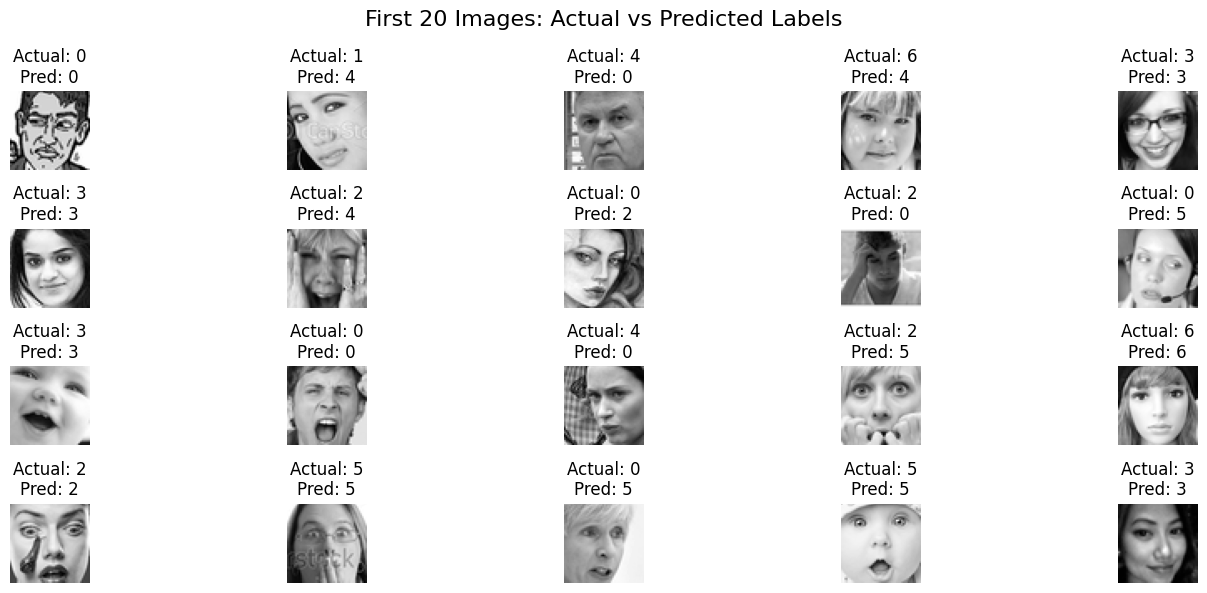

54.10977988297576

In [ ]:
test_model_first20(pre_trained_vgg, validation_dataloader, device)

# ResNeXt

Trying ResNeXt which is a more advanced convolution Network

It is better than conv cause it runs groups conv layers and runs them in parallel, which ensures there is no vanishing gradient, and takes less computation power.



In [ ]:
pip install efficientnet-pytorch

In [ ]:
from efficientnet_pytorch import EfficientNet

In [ ]:
# Model Definition
from torchvision.models import ResNeXt50_32X4D_Weights

def get_model(num_classes=7):  # 7 emotions
     weights = ResNeXt50_32X4D_Weights.DEFAULT
     model = models.resnext50_32x4d(weights=weights)
     model.conv1 = nn.Conv2d(
        in_channels=1,   # Changed input channels to 1 since our images are greyscale
        out_channels=model.conv1.out_channels,
        kernel_size=model.conv1.kernel_size,
        stride=model.conv1.stride,
        padding=model.conv1.padding,
        bias=False
    )
     model.fc = nn.Sequential(
    nn.Dropout(p=0.5),  # for overfitting
    nn.Linear(model.fc.in_features, num_classes)
)
     return model

# Instantiate the model
model = get_model(num_classes=7)
model = model.to(device)

print(model)


Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 146MB/s]


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [ ]:
# Training Setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4,weight_decay=1e-4)

## Training

In [ ]:
# Run Training

num_epochs = 20
train_model(model, train_dataloader, criterion, optimizer, device, epochs=num_epochs)

Epoch 1/20: 100%|██████████| 898/898 [00:54<00:00, 16.49it/s, acc=0.262, loss=0.281]


Epoch 1 Loss: 1.7941, Acc: 26.23%


Epoch 2/20: 100%|██████████| 898/898 [00:53<00:00, 16.93it/s, acc=0.378, loss=0.249]


Epoch 2 Loss: 1.5911, Acc: 37.78%


Epoch 3/20: 100%|██████████| 898/898 [00:53<00:00, 16.91it/s, acc=0.46, loss=0.219]


Epoch 3 Loss: 1.3989, Acc: 46.03%


Epoch 4/20: 100%|██████████| 898/898 [00:53<00:00, 16.91it/s, acc=0.544, loss=0.19]


Epoch 4 Loss: 1.2150, Acc: 54.40%


Epoch 5/20: 100%|██████████| 898/898 [00:53<00:00, 16.84it/s, acc=0.627, loss=0.158]


Epoch 5 Loss: 1.0082, Acc: 62.68%


Epoch 6/20: 100%|██████████| 898/898 [00:53<00:00, 16.87it/s, acc=0.716, loss=0.123]


Epoch 6 Loss: 0.7837, Acc: 71.65%


Epoch 7/20: 100%|██████████| 898/898 [00:53<00:00, 16.78it/s, acc=0.789, loss=0.0925]


Epoch 7 Loss: 0.5910, Acc: 78.90%


Epoch 8/20: 100%|██████████| 898/898 [00:53<00:00, 16.82it/s, acc=0.846, loss=0.0692]


Epoch 8 Loss: 0.4424, Acc: 84.59%


Epoch 9/20: 100%|██████████| 898/898 [00:53<00:00, 16.83it/s, acc=0.872, loss=0.0566]


Epoch 9 Loss: 0.3621, Acc: 87.21%


Epoch 10/20: 100%|██████████| 898/898 [00:53<00:00, 16.91it/s, acc=0.899, loss=0.0454]


Epoch 10 Loss: 0.2905, Acc: 89.87%


Epoch 11/20: 100%|██████████| 898/898 [00:53<00:00, 16.85it/s, acc=0.908, loss=0.0419]


Epoch 11 Loss: 0.2682, Acc: 90.80%


Epoch 12/20: 100%|██████████| 898/898 [00:53<00:00, 16.83it/s, acc=0.921, loss=0.0364]


Epoch 12 Loss: 0.2330, Acc: 92.10%


Epoch 13/20: 100%|██████████| 898/898 [00:53<00:00, 16.77it/s, acc=0.933, loss=0.031]


Epoch 13 Loss: 0.1979, Acc: 93.30%


Epoch 14/20: 100%|██████████| 898/898 [00:53<00:00, 16.82it/s, acc=0.938, loss=0.0287]


Epoch 14 Loss: 0.1835, Acc: 93.79%


Epoch 15/20: 100%|██████████| 898/898 [00:53<00:00, 16.90it/s, acc=0.938, loss=0.0282]


Epoch 15 Loss: 0.1806, Acc: 93.76%


Epoch 16/20: 100%|██████████| 898/898 [00:53<00:00, 16.86it/s, acc=0.947, loss=0.0248]


Epoch 16 Loss: 0.1585, Acc: 94.74%


Epoch 17/20: 100%|██████████| 898/898 [00:53<00:00, 16.75it/s, acc=0.953, loss=0.022]


Epoch 17 Loss: 0.1407, Acc: 95.29%


Epoch 18/20: 100%|██████████| 898/898 [00:53<00:00, 16.78it/s, acc=0.946, loss=0.0242]


Epoch 18 Loss: 0.1548, Acc: 94.60%


Epoch 19/20: 100%|██████████| 898/898 [00:53<00:00, 16.73it/s, acc=0.955, loss=0.021]


Epoch 19 Loss: 0.1344, Acc: 95.45%


Epoch 20/20: 100%|██████████| 898/898 [00:53<00:00, 16.86it/s, acc=0.957, loss=0.0193]

Epoch 20 Loss: 0.1232, Acc: 95.73%


## Testing

Testing: 100%|██████████| 113/113 [00:02<00:00, 52.37it/s]


Test Accuracy: 50.40%


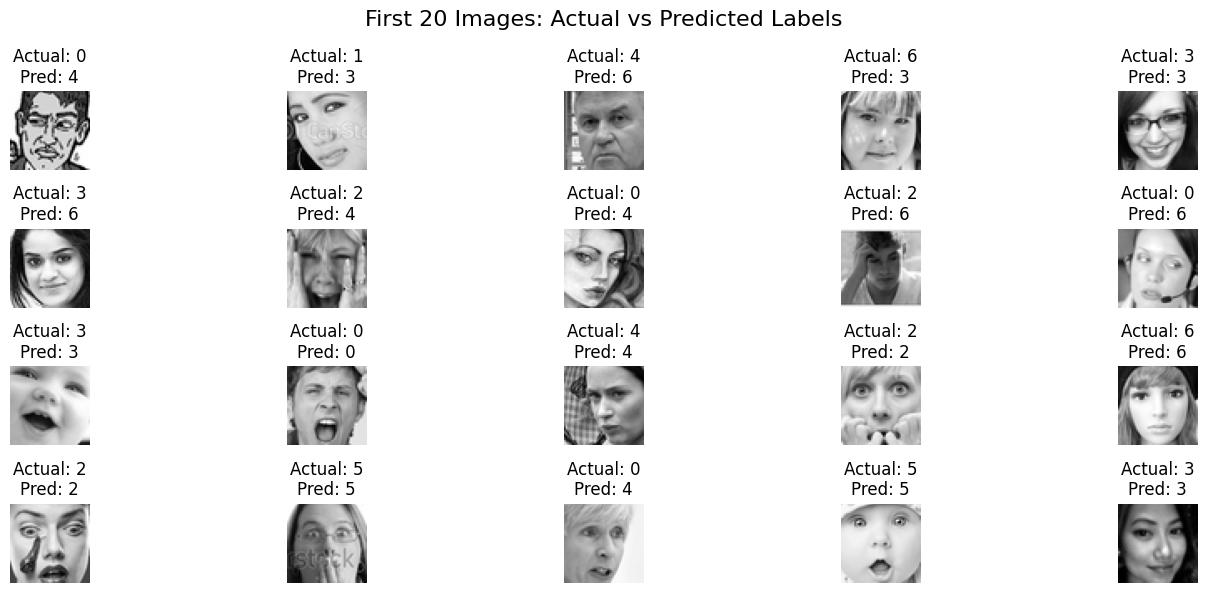

50.40401225968236

In [ ]:
test_model_first20(model, validation_dataloader, device)

In [ ]:
test_model(model, validation_dataloader, device)

Testing: 100%|██████████| 113/113 [00:02<00:00, 44.45it/s]

Test Accuracy: 50.40%


50.40401225968236

In [ ]:
test_model(model, test_dataloader, device)

Testing: 100%|██████████| 113/113 [00:02<00:00, 54.02it/s]

Test Accuracy: 52.33%


52.326553357481195

In [ ]:
test_model(model, train_dataloader, device)  # as per the results from this,
                                              # the model is not memoring the data,
                                              # otherwise this would have been
                                              # a 100% and it is just a rather
                                              # improperly labeled dataset

Testing: 100%|██████████| 898/898 [00:17<00:00, 51.93it/s]

Test Accuracy: 98.06%


98.05635863318123

The validation and test data seem to be way lower than the training data accuracy and this could be due to lack of data, or over fitting, which was taken care of using weight decay and dropout.